## Load Libraries

In [ ]:
print("Installing")
!pip install transformers --quiet
!pip install peft --quiet
!pip install tensorflow --quiet
!pip install nltk --quiet
!pip install datasets --quiet
!pip install rouge-score --quiet
!pip install -q -U bitsandbytes
!pip install -q trl
print("Finished")

Installing
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 14.7 MB/s eta 0:00:00
Finished


In [ ]:
import os
import json
import random

import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import random_split

from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model

import nltk
nltk.download('punkt')

from datasets import load_metric, Dataset

from tensorflow.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt

from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    BitsAndBytesConfig,
    TextStreamer
)

from trl import SFTTrainer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
from huggingface_hub import login
# input hugginface token here
login(token="")


Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Load Model

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.bfloat16,
    bnb_4bit_use_double_quant= False,
)

device = torch.device("cuda")
model_name = 'mistralai/Mistral-7B-Instruct-v0.1'
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
model = prepare_model_for_kbit_training(model)
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

max_token_index = tokenizer.vocab_size - 1

peft_config = LoraConfig(task_type="CASUAL_LM",
                                 lora_alpha=16,
                                 r=16,
                                 bias="none",
                                 lora_dropout=0.05,
                                 target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
                               )


model = get_peft_model(model, peft_config)

model = model.to(device)
model.print_trainable_parameters()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

trainable params: 23,068,672 || all params: 7,264,800,768 || trainable%: 0.3175403254224521


## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# return dataframe of jokes data
def read_jokes(json_file, sample_size):
    df = pd.read_json(json_file)
    # filter out for quality jokes of short length and single sentence punchlines
    end_punc = r'^.*?[.!?]$'
    df = df[(df['score'] > 20) & (df['body'].str.len() < 256) & (df['body'].str.match(end_punc))]
    df = df.sample(n=min(sample_size, len(df)), replace=False)

    return df

In [ ]:
# apply chat template format for Mistral to make dataframe
def MistralRedditJokes(data=None):
    df_data = []
    prompt = "You are a bot that responds to jokes with comedic punchlines "
    for index, row in data.iterrows():
        messages = []
        user_message = {"role": "user", "content": row['title']}
        assistant_message = {"role": "assistant", "content": row['body']}

        messages.append(user_message)
        messages.append(assistant_message)

        tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=False, return_tensors="pt")
        # Append the tokenized chat and the corresponding score to the list
        df_data.append({"Text": prompt + tokenized_chat, "Score": row['score']})

    # Create a DataFrame from the collected data
    df = pd.DataFrame(df_data)
    return df


In [ ]:
# prepare data if not already saved

# change this to wherever the data directory is
json_file = '/content/drive/MyDrive/reddit_jokes.json'

sample_size = 25000

data = read_jokes(json_file, sample_size)
train, remaining = train_test_split(data, test_size=0.1, random_state=42)
val, test = train_test_split(remaining, test_size=0.5, random_state=42)

train_dataset = Dataset.from_pandas(MistralRedditJokes(train))
val_dataset = Dataset.from_pandas(MistralRedditJokes(val))
test_dataset = Dataset.from_pandas(MistralRedditJokes(test))

In [ ]:
# Save or load dataset

#torch.save(train_dataset, '/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/train_dataset.pt')
#torch.save(val_dataset, '/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/val_dataset.pt')
#torch.save(test_dataset, '/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/test_dataset.pt')

#train_dataset = torch.load('/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/train_dataset.pt')
#val_dataset = torch.load('/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/val_dataset.pt')
#test_dataset = torch.load('/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/test_dataset.pt')

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

12503
695


In [ ]:
train_dataset['Text'][1]

'You are a bot that responds to jokes with comedic punchlines <s>[INST] A dick has a sad life. [/INST]His hair is a mess, his family is nuts, his neighbor is an asshole, his best friend is a pussy, and his owner beats him.</s> '

## Evaluation Metric Setup

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    try:
      predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
      predictions = np.where(predictions <= max_token_index, predictions, tokenizer.pad_token_id)
      decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

      # Replace -100 in the labels as we can't decode them.
      # if token out of vocab size, cap it
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
      labels = np.where(labels <= max_token_index, labels, tokenizer.pad_token_id)
      decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    except Exception as e:
        print("Error decoding predictions or labels:", e)
        return {"rouge1": 0, "rouge2": 0, "rougeL": 0, "gen_len": 0}


    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip()))
                      for label in decoded_labels]

    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    # Extract ROUGE f1 scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

## Trainer

In [ ]:
metric = load_metric('rouge')

model_dir = f"drive/MyDrive/Models/{model_name}val"

training_args = TrainingArguments(
    model_dir,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=2,
    weight_decay=0.001,
    max_grad_norm=0.3,
    optim="paged_adamw_8bit",
    logging_strategy='steps',
    logging_steps=100,
    save_strategy="steps",
    save_steps=200,
    warmup_ratio= 0.3,
    group_by_length= True,
    lr_scheduler_type= "constant",
    report_to='tensorboard'
)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
def model_init():
    model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
    model = prepare_model_for_kbit_training(model)
    model.config.pretraining_tp = 1
    model.gradient_checkpointing_enable()
    peft_config = LoraConfig(task_type="CASUAL_LM",
                                    lora_alpha=16,
                                    r=8,
                                    bias="none",
                                    lora_dropout=0.05,
                                    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
                                  )

    model = get_peft_model(model, peft_config).to(device)
    return model

trainer = SFTTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics,
    max_seq_length=256,
    dataset_text_field="Text",
)


Map:   0%|          | 0/12503 [00:00<?, ? examples/s]

Map:   0%|          | 0/695 [00:00<?, ? examples/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '{model_dir}'/runs

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

{'eval_runtime': 538.7791,
 'eval_samples_per_second': 1.29,
 'eval_steps_per_second': 1.29}

## Evaluation

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

dir = '/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/Mistral-7B-Instruct-v0.1v1'

bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.bfloat16,
    bnb_4bit_use_double_quant= False,
)

device = torch.device("cuda")
model = AutoModelForCausalLM.from_pretrained(dir, quantization_config=bnb_config)

tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-Instruct-v0.1', trust_remote_code=True,
                                          padding_side='left')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

max_token_index = tokenizer.vocab_size - 1

model = PeftModel.from_pretrained(model, dir, device_map={"":0})
model.eval()

model = model.to(device)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Inference

In [ ]:
def stream(user_prompt):
    runtimeFlag = "cuda:0"
    system_prompt = 'You are a bot that responds to jokes with comedic punchlines \n'
    B_INST, E_INST = "[INST]", "[/INST]"

    prompt = f"{system_prompt}{B_INST}{user_prompt.strip()}\n{E_INST}"

    inputs = tokenizer([prompt], return_tensors="pt").to(runtimeFlag)

    output = model.generate(**inputs, max_new_tokens=50)
    text = tokenizer.decode(output[0], skip_special_tokens=True)

    # Find the position of [/INST]
    end_inst_position = text.find("[/INST]") + len("[/INST]")

    # Find the first period after [/INST]
    period_position = text.find(".", end_inst_position)

    # Extract the string between [/INST] and the first period
    if period_position > -1:
        extracted_text = text[end_inst_position:period_position].strip()
    else:
        extracted_text = text[end_inst_position:].strip()  # If no period, take everything after [/INST]

    return extracted_text

In [ ]:
h = stream("How many police officiers does it take to change a lightbulb?")
print(h)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


None, they'll just arrest it


## Accessing Training Logs

In [ ]:
logdir = "/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/runs/Apr16_21-25-43_181ca75ce4c9"

In [ ]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data
path=logdir #folderpath
df=tflog2pandas(path)
#df=df[(df.metric != 'params/lr')&(df.metric != 'params/mm')&(df.metric != 'train/loss')] #delete the mentioned rows
df.to_csv("/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1/Mistral-7B-Instruct-v0.1v1/mistralmetrics.csv")

In [ ]:
df.metric.unique()

array(['train/loss', 'train/grad_norm', 'train/learning_rate',
       'train/epoch', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'train/total_flos', 'train/train_loss'], dtype=object)

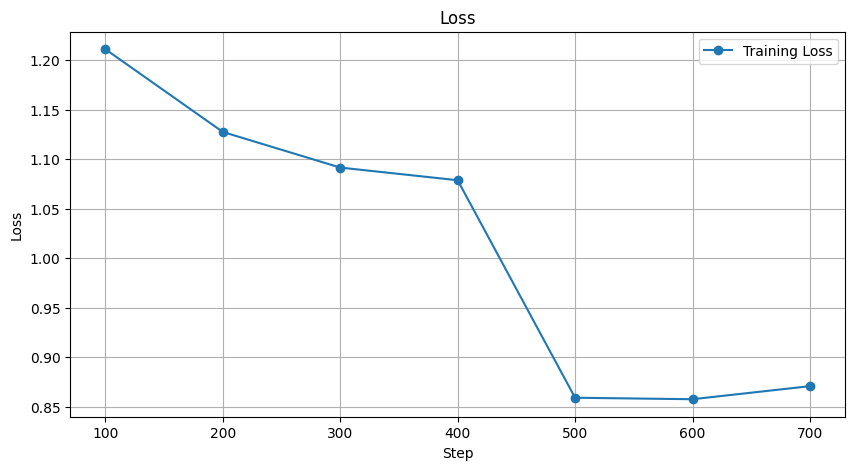

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame by metric
train_loss_df = df[df['metric'] == 'train/loss']


# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['step'], train_loss_df['value'], label='Training Loss', marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
logdir = "/content/drive/MyDrive/Models/mistralai/Mistral-7B-Instruct-v0.1val/runs/Apr21_23-30-28_924bd0dc7690"